In [7]:
'''
This notebook applies several regressors of sklearn library to the same data 
set used in network_profile_recommender project
(https://github.com/fleapapa/network_profile_recommender) 
to predict effective PHY rates of network endpoints. Effective PHY rate can be view 
as performance or a health index of a network endpoint, because it is net throughput 
of the endpoint, considering all internal and external factors that can affect 
how the endpoint communicates with its peers.

This notebook trains the regressors with 2M data samples of observed network metrics and 
the pre-aggregated values of the samples such as 1-hour moving averages and delta of 
network metrics, test the model to learn scores of how predictions perform. 

Charts are plotted to show performance of each regressor.

Another notebook, https://github.com/fleapapa/network_performance_prediction
/blob/master/sklearn/regressors-no-avg-delta.ipynb,
does similar exercise, except it excludes the pre-aggregated values. Without 
the pre-aggregated value to carry time-series information in shuffled training 
data, prediction performance is obviously worse than that of this notebook.
'''

%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import random
import pandas
import numpy
import tensorflow
import time
import math

from sklearn import metrics
from sklearn import preprocessing
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

# import various kinds of regressors
from sklearn import ensemble
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

In [2]:
%%time
# use the same dataset as used by recommender
df_raw = pandas.read_csv('../data/etl2M.csv',header=None)
df_x = df_raw.ix[:, 1:17]   # x = features (observations)
df_y = df_raw.ix[:, 18]     # y = labels

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, 
    test_size=0.01, 
    random_state=42,
    )

CPU times: user 3.49 s, sys: 26.8 s, total: 30.2 s
Wall time: 30.2 s


In [3]:
def time2str(tstart, tag):
    tsec = time.time() - tstart
    tmin = tsec // 60
    tsec = tsec %  60
    thrs = tmin // 60
    tmin = tmin %  60
    return '%s=%02d:%02d:%02d' % (tag, thrs, tmin, tsec)

def plot_chart(truths, predictions, algo_name, tuse, rmse_score):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    plt.scatter(numpy.arange(0, len(truths)),      truths,      c='b', s=2, label='ground truth') 
    plt.scatter(numpy.arange(0, len(predictions)), predictions, c='r', s=2, label='prediction')                                                                                                  
    plt.axis('tight')                                                                                                                           
    plt.legend()                                                                                                                                
    plt.title("%s: %s %s" % (algo_name, tuse, rmse_score))                                                                                                                                      
    plt.savefig("/data/tmp/sklearn/%s.png" % algo_name) 
    plt.grid()
    plt.show()
    plt.clf()


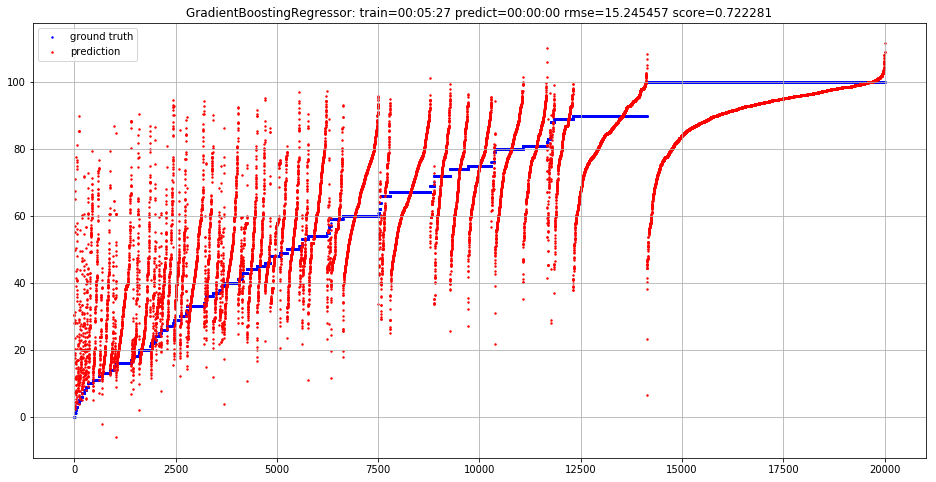

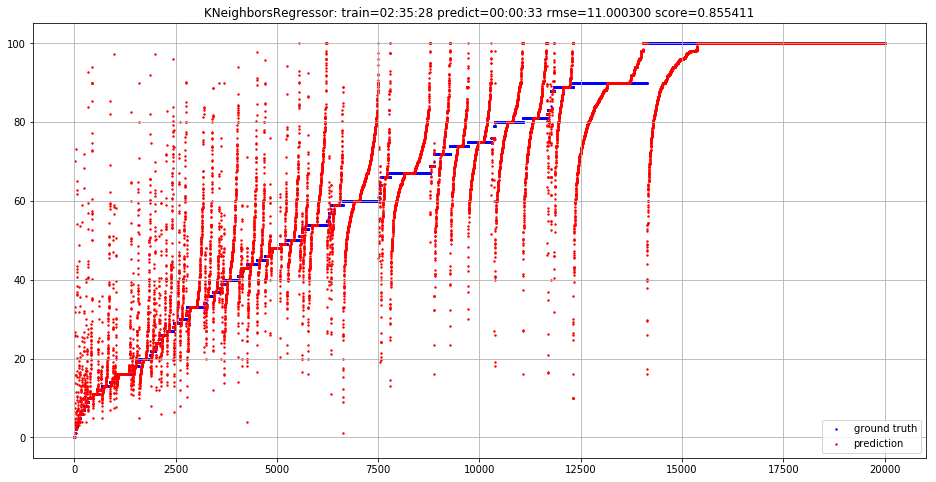

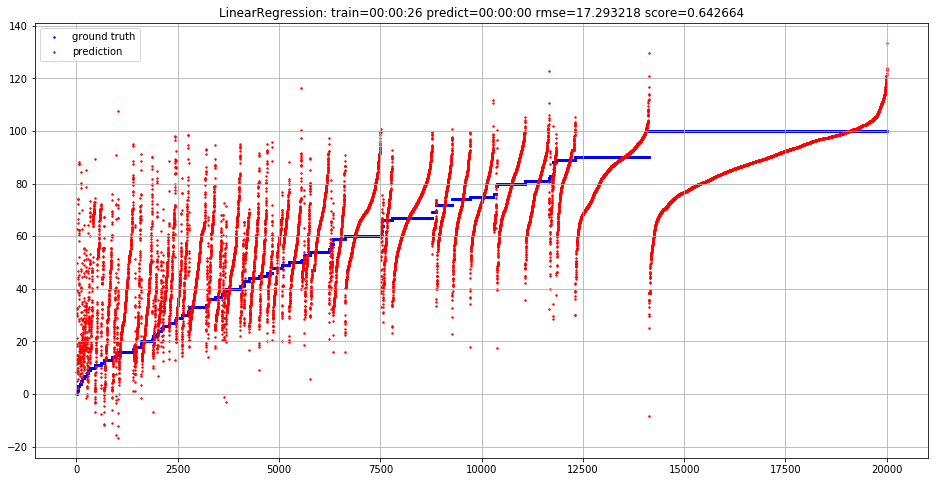

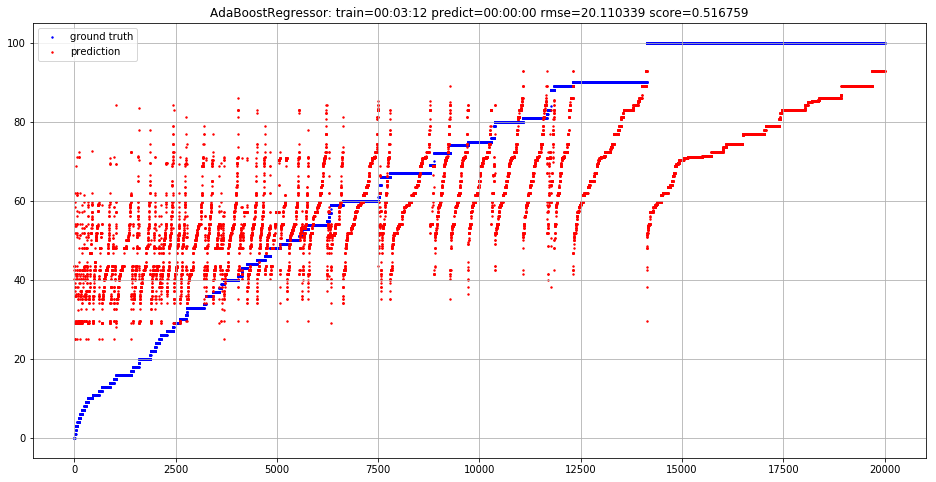

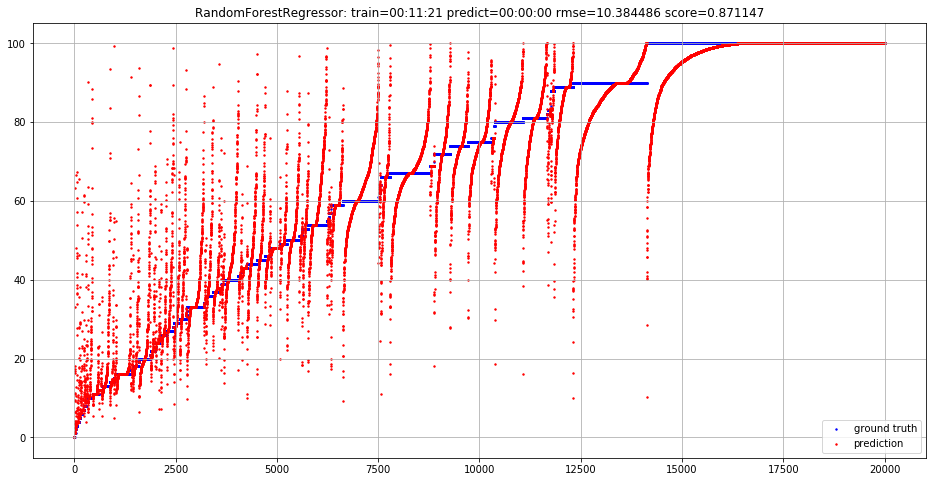

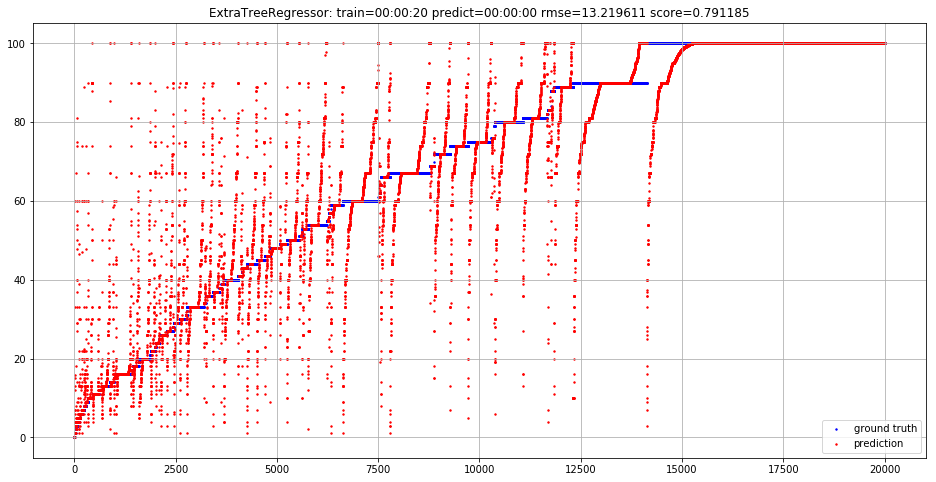

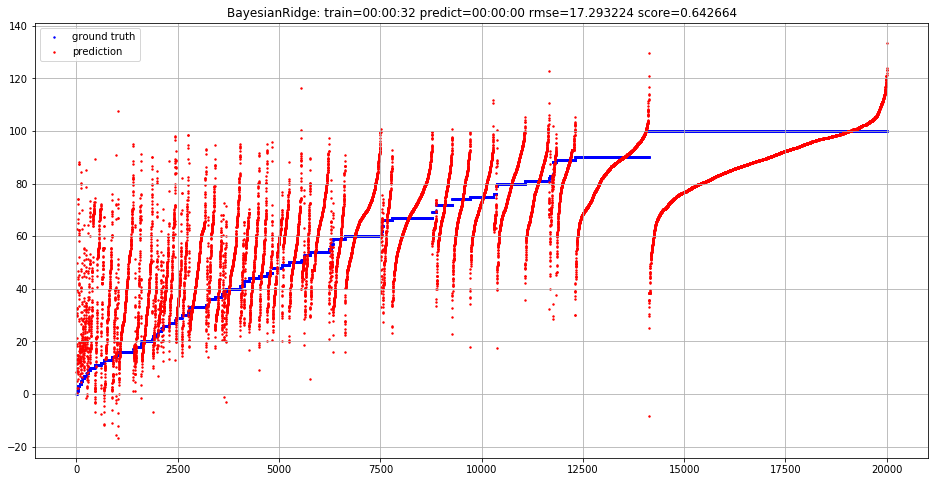

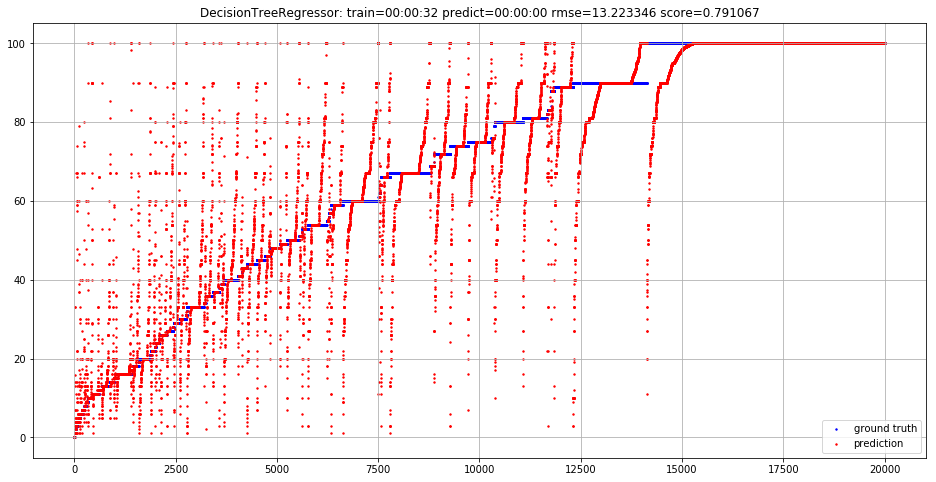

CPU times: user 2h 55min 15s, sys: 3min 40s, total: 2h 58min 55s
Wall time: 2h 58min 39s


In [10]:
%%time
algorithms = {
    'DecisionTreeRegressor':      tree.DecisionTreeRegressor(),
    'ExtraTreeRegressor':         tree.ExtraTreeRegressor(),
    'RandomForestRegressor':      ensemble.RandomForestRegressor(n_estimators=40),
    'AdaBoostRegressor':          ensemble.AdaBoostRegressor(),
    'GradientBoostingRegressor':  ensemble.GradientBoostingRegressor(),
    'KNeighborsRegressor':        neighbors.KNeighborsRegressor(5, weights='distance'),
    'LinearRegression':           linear_model.LinearRegression(),
    'BayesianRidge':              linear_model.BayesianRidge(),
#    'LogisticRegression':         linear_model.LogisticRegression(),
}                                  

for algo_name in algorithms:
    # train
    tstart = time.time()
    algorithm = algorithms[algo_name]
    model = algorithm.fit(x_train, y_train)
    tuse = time2str(tstart, 'train')

    # predict
    tstart = time.time()
    y_predicted = model.predict(x_test)                                                                                                              
    tuse = tuse + " " + time2str(tstart, 'predict')

    # evaluate
    truths_predictions = zip(y_test, y_predicted)
    rmse = math.sqrt(numpy.mean(map(lambda (t, p): (t - p) * (t - p), truths_predictions)))
    rmse_score = 'rmse={0:f}'.format(rmse)

    score = model.score(x_test, y_test)
    rmse_score += ' score={0:f}'.format(score)

    # plot
    # !! intact y_test & y_predicted for next algorithm !!
    p_test, p_predicted = zip(*sorted(zip(y_test, y_predicted)))
    plot_chart(p_test, p_predicted, algo_name, tuse, rmse_score)


From the charts above, RandomForestRegressor and KNeighborsRegressor scored 
more accurcy than the other regressors, but DecisionTreeRegressor and 
ExtraTreeRegressor scored much more accuracy per used second.